In [13]:
import numpy as np
from custom_dataloader import replicate_data
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib

In [16]:
def bootstrap_estimate(estimator, X, Y, amounts_train, amounts_val, n_splits=100):
                          
    scoresA = []
    scoresP = []
    scoresR = []
    
    for n in range(0,n_splits):
        inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, random.randint(0,1000))
        scaler_S = StandardScaler().fit(inp_tr)
        inp_tr = scaler_S.transform(inp_tr)
        inp_va = scaler_S.transform(inp_va)
        # inp_te = scaler_S.transform(inp_te)
        estimator.fit(inp_tr, tar_tr.ravel())  
        pred_va = estimator.predict(inp_va)
        scoresA.append(accuracy_score(tar_va,pred_va))
        scoresR.append(recall_score(tar_va,pred_va,average=None,zero_division=1))  
        scoresP.append(precision_score(tar_va,pred_va,average=None,zero_division=1)) 
        
    scoresR = list(map(list, zip(*scoresR)))
    scoresP = list(map(list, zip(*scoresP)))

    estimateA = np.mean(scoresA)*100.
    stderrA = np.std(scoresA)*100.
    
    estimateR = [np.mean(scoresR[0])*100.,np.mean(scoresR[1])*100.,np.mean(scoresR[2])*100.]
    stderrR = [np.std(scoresR[0])*100.,np.std(scoresR[1])*100.,np.std(scoresR[2])*100.]
    
    estimateP = [np.mean(scoresP[0])*100.,np.mean(scoresP[1])*100.,np.mean(scoresP[2])*100.]
    stderrP = [np.std(scoresP[0])*100.,np.std(scoresP[1])*100.,np.std(scoresP[2])*100.]
    
    return estimateR, stderrR, estimateP, stderrP, estimateA, stderrA

def bootstrap_to_file(file, estimator, X, Y, amounts_train, amounts_val, n_splits=200):
    estR, stderrR, estP, stderrP, estA, stderrA = bootstrap_estimate(estimator, X, Y, amounts_train, amounts_val, n_splits=n_splits)
    classes = ["Class I", "Class II", "Contaminants"]
    for i, cl in enumerate(classes):
        if i==1:
            file.write(cl+"& $"+"{:.1f}".format(estR[i])+"\pm"+"{:.1f}".format(stderrR[i])+"$ & $"+
                "{:.1f}".format(estP[i])+"\pm"+"{:.1f}".format(stderrP[i])+"$ & $"+"{:.1f}".format(estA)+"\pm"+"{:.1f}".format(stderrA)+"$ // \n")
        else:
            file.write(cl+"& $"+"{:.1f}".format(estR[i])+"\pm"+"{:.1f}".format(stderrR[i])+"$ & $"+
                "{:.1f}".format(estP[i])+"\pm"+"{:.1f}".format(stderrP[i])+"$&// \n")


In [14]:
# Data Set-Up

# Train on SPICY classifications
X = np.load("../Data_and_Results/Inputs_YSO_Train.npy") # Load input data
Y = np.load("../Data_and_Results/Targets_YSO_Train.npy") # Load target data

train_amount = [3000,3000,3000,3000]
valid_amount = [6726,25687,10162,2300]

inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, train_amount, valid_amount)

# Test on 
inp_te = np.load("../Data_and_Results/Inputs_YSO_alpha.npy") # Load input data
tar_te = np.load("../Data_and_Results/Targets_YSO_alpha.npy") # Load target data

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)
inp_te = scaler_S.transform(inp_te) 

# custom_labs = ['YSO','EG','Star']
custom_labs = ['Class I', 'Flat-Spectrum', 'Class II', 'Class III']

In [15]:
boostcl = GradientBoostingClassifier(criterion='friedman_mse',max_depth=5,max_features='log2',
                n_estimators=150,n_iter_no_change=5,subsample=1.0,warm_start=False)
rfcl = RandomForestClassifier(class_weight='balanced',criterion='entropy',max_features='log2',n_estimators=50,oob_score=False)


In [16]:
boostcl.fit(inp_tr,tar_tr.ravel())



GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=150,
                           n_iter_no_change=5)

0.9561720894986778


/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

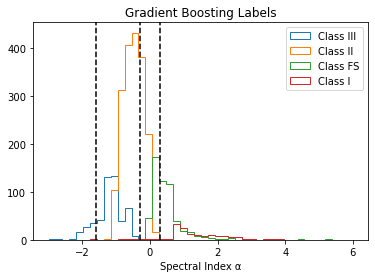

In [17]:
pred_tr = boostcl.predict(inp_tr)
pred_va = boostcl.predict(inp_va)
pred_te = boostcl.predict(inp_te)

scores_va = boostcl.predict_proba(inp_va)

print(roc_auc_score(tar_va.ravel(),scores_va,multi_class='ovo'))
bins = np.linspace(-3, 6, 45)

aIII = np.where(pred_te==3.)
plt.hist(inp_te[aIII].transpose()[8],bins,histtype='step',label='Class III')
aII = np.where(pred_te==2.)
plt.hist(inp_te[aII].transpose()[8],bins,histtype='step',label='Class II')
aFS = np.where(pred_te==1.)
plt.hist(inp_te[aFS].transpose()[8],bins,histtype='step',label='Class FS')
aI = np.where(pred_te==0.)
plt.hist(inp_te[aI].transpose()[8],bins,histtype='step',label='Class I')
plt.axvline(x=-1.6,color='k', linestyle='--')
plt.axvline(x=-0.3,color='k', linestyle='--')
plt.axvline(x=0.3,color='k', linestyle='--')

plt.legend()
plt.xlabel('Spectral Index α')
plt.title('Gradient Boosting Labels')
with open("../Data_and_Results/YSO_GB_alphas_Classification_Report.txt",'w') as f:
    f.write("Training Set Report")
    f.write(classification_report(tar_tr,pred_tr,target_names=custom_labs))
    f.write("Validation Set Report")
    f.write(classification_report(tar_va,pred_va,target_names=custom_labs))
    f.write("Test Set Report")
    f.write(classification_report(tar_te,pred_te,target_names=custom_labs))

In [18]:
rfcl.fit(inp_tr,tar_tr.ravel())

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=50)

0.9520916277726169


/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/breannacrompvoets/miniforge3/envs/SF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

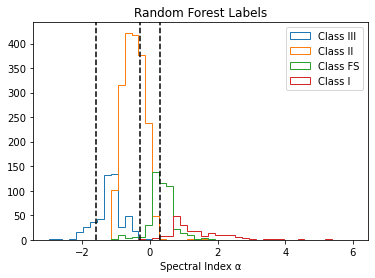

In [19]:
pred_tr = rfcl.predict(inp_tr)
pred_va = rfcl.predict(inp_va)
pred_te = rfcl.predict(inp_te)
scores_va = rfcl.predict_proba(inp_va)

print(roc_auc_score(tar_va.ravel(),scores_va,multi_class='ovo'))
bins = np.linspace(-3, 6, 45)

aIII = np.where(pred_te==3.)
plt.hist(inp_te[aIII].transpose()[8],bins,histtype='step',label='Class III')
aII = np.where(pred_te==2.)
plt.hist(inp_te[aII].transpose()[8],bins,histtype='step',label='Class II')
aFS = np.where(pred_te==1.)
plt.hist(inp_te[aFS].transpose()[8],bins,histtype='step',label='Class FS')
aI = np.where(pred_te==0.)
plt.hist(inp_te[aI].transpose()[8],bins,histtype='step',label='Class I')
plt.axvline(x=-1.6,color='k', linestyle='--')
plt.axvline(x=-0.3,color='k', linestyle='--')
plt.axvline(x=0.3,color='k', linestyle='--')
plt.legend()
plt.xlabel('Spectral Index α')
plt.title('Random Forest Labels')

with open("../Data_and_Results/YSO_RF_alphas_Classification_Report.txt",'w') as f:
    f.write("Training Set Report")
    f.write(classification_report(tar_tr,pred_tr,target_names=custom_labs))
    f.write("Validation Set Report")
    f.write(classification_report(tar_va,pred_va,target_names=custom_labs))
    f.write("Test Set Report")
    f.write(classification_report(tar_te,pred_te,target_names=custom_labs))

In [20]:
joblib.dump(rfcl,"../Data_and_Results/YSO_RF_alpha_Settings.joblib")

['../Data_and_Results/YSO_RF_alpha_Settings.joblib']